In this script, we will see the linear programming outputs for gameweek 1, i.e the initial team from which we build our transfers on. We will compare the effect of using the cheapest bench and the effect of using an optimised bench as well as the effect of the two different models built in Predictions.ipynb

In [1]:
import Utils
import pandas as pd
import pulp
import matplotlib.pyplot as plt

# Model A: All Positions Modelled Together

In [2]:
orig_data = pd.read_csv('all_with_history.csv')

C:\Users\Tasha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## With Bench Optimisation

In [3]:
all_results = pd.read_csv('all_predictions.csv')
gw_1 = all_results[all_results.GW == 1]

In [4]:
def linear_prog(df, max_budget = 1000, gk_constraint = 2, def_constraint = 5, fwd_constraint = 3,
                mid_constraint = 5):
    
    #define the sets
    pos = df.position.unique()
    teams = df.player_team_name.unique()
    
    #define the constraints
    pos_constraint = {'GK': gk_constraint, 'DEF': def_constraint, 'MID': mid_constraint, 'FWD': fwd_constraint}
    
    #set up decision variables
    positions, clubs, names, values,  points, decision_vars = [], [], [], [], [], []
    for i in df.index:
        positions.append(df.position[i])
        clubs.append(df.player_team_name[i])
        names.append(df.full_name[i])
        values.append(df.value[i])
        points.append(df.predicted[i])
        decision_vars.append(pulp.LpVariable("x_" + str(i), cat = 'Binary')) #this makes variables like x_1, x_2 for the players
      
    #define the objective function
    prob = pulp.LpProblem("Initialisation", pulp.LpMaximize) #maximisation problem
    prob += pulp.lpSum(decision_vars[i] * points[i] for i in range(len(df))) #objective to maximise
    
    #set the constraints/add them to the problem
    prob += pulp.lpSum(decision_vars[i] * df.value[df.index[i]] for i in range(len(df))) <= max_budget
    prob += pulp.lpSum(decision_vars[i] for i in range(len(df))) == 15
    
    for p in pos:
      prob += pulp.lpSum(decision_vars[i] for i in range(len(df)) if positions[i] == p) <= pos_constraint[p]

    for t in teams:
      prob += pulp.lpSum(decision_vars[i] for i in range(len(df)) if clubs[i] == t) <= 3 

    #solve problem
    prob.solve()
    
    return prob

In [5]:
pr = linear_prog(gw_1,max_budget = 1000, gk_constraint = 2, def_constraint = 5, fwd_constraint = 3,
                mid_constraint = 5) #create linear programming solutions

In [6]:
all_opt = Utils.construct_best_team(gw_1, pr) #get output df
(all_opt.sort_values('Predicted Points', ascending = False))

,Name,Team,Position,Value,Predicted Points,Actual Points
8,harry_kane,Tottenham Hotspur,FWD,125,6.018652,0
5,bruno_miguel_borges_fernandes,Manchester United,MID,120,5.842343,20
7,heung_min_son,Tottenham Hotspur,MID,100,4.845485,10
14,patrick_bamford,Leeds,FWD,80,4.226871,2
13,dominic_calvert_lewin,Everton,FWD,80,3.837465,7
1,stuart_dallas,Leeds,MID,55,2.791295,5
12,rúben_diogo_da_silva_neves,Wolverhampton Wanderers,MID,55,2.729365,2
11,tyrone_mings,Aston Villa,DEF,50,2.704036,0
10,michael_keane,Everton,DEF,50,2.698173,2
4,james_tarkowski,Burnley,DEF,50,2.692284,6


In [7]:
bench_dict1 = Utils.pick_bench(all_opt)

In [8]:
%store bench_dict1

Stored 'bench_dict1' (dict)


In [39]:
bench_dict1

{'GK': 'alex_mccarthy',
 'FWD': 'dominic_calvert_lewin',
 'MID': 'yves_bissouma',
 'DEF': 'ezri_konsa_ngoyo'}

In [9]:
old_team1, subbed_team1 = Utils.make_subs(all_opt, orig_data, 1, bench_dict1)

In [10]:
%store old_team1

Stored 'old_team1' (list)


In [11]:
all_opt = all_opt[all_opt.Name.isin(subbed_team1)].sort_values('Predicted Points')

In [12]:
all_opt['Actual Points'].sum()+20

78

In [13]:
bench_dict1

{'GK': 'alex_mccarthy',
 'FWD': 'dominic_calvert_lewin',
 'MID': 'yves_bissouma',
 'DEF': 'ezri_konsa_ngoyo'}

In [14]:
all_opt

,Name,Team,Position,Value,Predicted Points,Actual Points
3,vicente_guaita,Crystal Palace,GK,45,2.474283,2
2,lewis_dunk,Brighton and Hove Albion,DEF,50,2.665089,2
4,james_tarkowski,Burnley,DEF,50,2.692284,6
10,michael_keane,Everton,DEF,50,2.698173,2
11,tyrone_mings,Aston Villa,DEF,50,2.704036,0
12,rúben_diogo_da_silva_neves,Wolverhampton Wanderers,MID,55,2.729365,2
1,stuart_dallas,Leeds,MID,55,2.791295,5
13,dominic_calvert_lewin,Everton,FWD,80,3.837465,7
14,patrick_bamford,Leeds,FWD,80,4.226871,2
7,heung_min_son,Tottenham Hotspur,MID,100,4.845485,10


## With Cheapest Bench

In [15]:
gk_cheap = all_results[(all_results.position == 'GK') & (all_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value','position','actual']]
def_cheap = all_results[(all_results.position == 'DEF') & (all_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value','position','actual']]
mid_cheap = all_results[(all_results.position == 'MID') & (all_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value', 'position','actual']]
fwd_cheap = all_results[(all_results.position == 'FWD') & (all_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value', 'position', 'actual']]

In [16]:
cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])

In [17]:
cheapest

,full_name,player_team_name,value,position,actual
11783,ellery_balcombe,Brentford,40,GK,0
10529,charlie_goode,Brentford,40,DEF,0
18583,yves_bissouma,Brighton and Hove Albion,45,MID,2
1140,stipe_perica,Watford,45,FWD,0


In [18]:
t3, t2, t1, t0 = Utils.modify_team_constraints(cheapest, all_results)

In [19]:
pr = Utils.linear_prog_with_bench(cheapest, gw_1, max_budget = 830, gk_constraint = 1, def_constraint = 4, fwd_constraint = 2,
                mid_constraint = 4)

In [20]:
all_cheap = Utils.construct_best_team(all_results, pr)

In [21]:
all_cheap

,Name,Team,Position,Value,Predicted Points,Actual Points
0,stuart_dallas,Leeds,MID,55,2.791295,5
1,lewis_dunk,Brighton and Hove Albion,DEF,50,2.665089,2
2,vicente_guaita,Crystal Palace,GK,45,2.474283,2
3,james_tarkowski,Burnley,DEF,50,2.692284,6
4,jack_grealish,Manchester City,MID,80,3.826221,1
5,bruno_miguel_borges_fernandes,Manchester United,MID,120,5.842343,20
6,harry_kane,Tottenham Hotspur,FWD,125,6.018652,0
7,michael_keane,Everton,DEF,50,2.698173,2
8,tyrone_mings,Aston Villa,DEF,50,2.704036,0
9,mohamed_salah,Liverpool,MID,125,6.007502,17


In [22]:
bench_dict2 = {'GK': 'ellery_balcombe', 'FWD': 'stipe_perica', 'MID': 'yves_bissouma', 'DEF': 'charlie_goode'}

In [23]:
old_team2, subbed_team2 = Utils.make_subs(all_cheap, orig_data, 1, bench_dict2)

In [24]:
%store bench_dict2
%store old_team2

Stored 'bench_dict2' (dict)
Stored 'old_team2' (list)


In [136]:
cheapest = cheapest.rename(columns = {'full_name': 'Name', 'player_team_name': 'Team', 'position': 'Position', 'value': 'Value',
                          'predicted': 'Predicted Points', 'actual': 'Actual Points'})
all_and_cheap = pd.concat([all_cheap, cheapest])

In [137]:
all_and_cheap

,Name,Team,Position,Value,Predicted Points,Actual Points
0,stuart_dallas,Leeds,MID,55,2.791295,5
1,lewis_dunk,Brighton and Hove Albion,DEF,50,2.665089,2
2,vicente_guaita,Crystal Palace,GK,45,2.474283,2
3,james_tarkowski,Burnley,DEF,50,2.692284,6
4,jack_grealish,Manchester City,MID,80,3.826221,1
5,bruno_miguel_borges_fernandes,Manchester United,MID,120,5.842343,20
7,michael_keane,Everton,DEF,50,2.698173,2
8,tyrone_mings,Aston Villa,DEF,50,2.704036,0
9,mohamed_salah,Liverpool,MID,125,6.007502,17
10,patrick_bamford,Leeds,FWD,80,4.226871,2


In [138]:
all_and_cheap = all_and_cheap[all_and_cheap.Name.isin(subbed_team2)]

In [139]:
all_and_cheap.sort_values('Predicted Points') 
#bissouma is NaN because this wasnt included in the bench df, there is a prediction for him however

,Name,Team,Position,Value,Predicted Points,Actual Points
2,vicente_guaita,Crystal Palace,GK,45,2.474283,2
1,lewis_dunk,Brighton and Hove Albion,DEF,50,2.665089,2
3,james_tarkowski,Burnley,DEF,50,2.692284,6
7,michael_keane,Everton,DEF,50,2.698173,2
8,tyrone_mings,Aston Villa,DEF,50,2.704036,0
0,stuart_dallas,Leeds,MID,55,2.791295,5
4,jack_grealish,Manchester City,MID,80,3.826221,1
10,patrick_bamford,Leeds,FWD,80,4.226871,2
5,bruno_miguel_borges_fernandes,Manchester United,MID,120,5.842343,20
9,mohamed_salah,Liverpool,MID,125,6.007502,17


In [140]:
all_and_cheap['Actual Points'].sum()+17

74

# Model B: Using Separate Position Models

In [141]:
gk_df = pd.read_csv('gk_predictions.csv')
def_df = pd.read_csv('def_predictions.csv')
mid_df = pd.read_csv('mid_predictions.csv')
fwd_df = pd.read_csv('fwd_predictions.csv')

In [142]:
sep_df = pd.concat([gk_df, def_df, mid_df,fwd_df])

In [143]:
sep_df.to_csv('separated_predictions.csv')

## Optimised Bench

In [144]:
sep_results = sep_df[sep_df.GW == 1]
sep_results = sep_results.reset_index()

In [145]:
pr = linear_prog(sep_results, max_budget = 1000, gk_constraint = 2, def_constraint = 5, fwd_constraint = 3,
                mid_constraint = 5)

In [146]:
sep_opt = Utils.construct_best_team(sep_results, pr)
sep_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
8,stuart_dallas,Leeds,MID,55,2.217357,5
13,neal_maupay,Brighton and Hove Albion,FWD,65,2.640161,5
4,luke_ayling,Leeds,DEF,45,2.723339,6
3,lewis_dunk,Brighton and Hove Albion,DEF,50,2.813788,2
1,nélson_cabral_semedo,Wolverhampton Wanderers,DEF,50,2.832647,0
2,kieran_tierney,Arsenal,DEF,50,2.890085,1
7,vicente_guaita,Crystal Palace,GK,45,3.157030,2
14,luke_shaw,Manchester United,DEF,55,3.170015,1
6,diogo_jota,Liverpool,MID,75,3.174002,8
12,ollie_watkins,Aston Villa,FWD,75,3.177184,0


In [147]:
bench_dict3 = Utils.pick_bench(sep_opt)

In [148]:
bench_dict3

{'GK': 'vicente_guaita',
 'FWD': 'neal_maupay',
 'MID': 'stuart_dallas',
 'DEF': 'luke_ayling'}

In [149]:
old_team3, subbed_team3 = Utils.make_subs(sep_opt, orig_data, 1, bench_dict3)

In [150]:
%store bench_dict3
%store old_team3

Stored 'bench_dict3' (dict)
Stored 'old_team3' (list)


In [151]:
orig_data[(orig_data.full_name == 'ollie_watkins') & (orig_data.GW ==1)] #checking ollie definitely played

,Unnamed: 0,index,assists,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,last_yr_minutes,last_yr_own_goals,last_yr_penalties_missed,last_yr_penalties_saved,last_yr_points_per_game,last_yr_red_cards,last_yr_saves,last_yr_transfers_in,last_yr_transfers_out,last_yr_yellow_cards
124186,124186,247,0,NaN,NaN,0,0,0,NaN,NaN,...,3328.0,0.0,1.0,0.0,4.0,1.0,0.0,4635254.0,3049913.0,2.0


In [152]:
sep_opt = sep_opt[sep_opt.Name.isin(subbed_team3)].sort_values('Predicted Points')

In [153]:
sep_opt

,Name,Team,Position,Value,Predicted Points,Actual Points
13,neal_maupay,Brighton and Hove Albion,FWD,65,2.640161,5
3,lewis_dunk,Brighton and Hove Albion,DEF,50,2.813788,2
2,kieran_tierney,Arsenal,DEF,50,2.890085,1
7,vicente_guaita,Crystal Palace,GK,45,3.157030,2
14,luke_shaw,Manchester United,DEF,55,3.170015,1
6,diogo_jota,Liverpool,MID,75,3.174002,8
12,ollie_watkins,Aston Villa,FWD,75,3.177184,0
11,gabriel_fernando_de_jesus,Manchester City,FWD,85,3.551386,1
9,jack_grealish,Manchester City,MID,80,3.774851,1
10,heung_min_son,Tottenham Hotspur,MID,100,5.606365,10


In [154]:
sep_opt['Actual Points'].sum()+20

71

## Cheapest Bench

In [73]:
gk_cheap = sep_results[(sep_results.position == 'GK') & (sep_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value','position','actual']]
def_cheap = sep_results[(sep_results.position == 'DEF') & (sep_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value','position','actual']]
mid_cheap = sep_results[(sep_results.position == 'MID') & (sep_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value', 'position','actual']]
fwd_cheap = sep_results[(sep_results.position == 'FWD') & (sep_results.GW == 1)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'value', 'position', 'actual']]

In [74]:
cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])

In [81]:
cheapest

,full_name,player_team_name,value,position,actual
23,ellery_balcombe,Brentford,40,GK,0
110,neco_williams,Liverpool,40,DEF,0
441,josh_brownhill,Burnley,45,MID,1
482,stipe_perica,Watford,45,FWD,0


In [82]:
bench_dict4 = {'GK': 'ellery_balcombe', 'DEF': 'neco_williams','MID':'josh_brownhill', 'FWD': 'stipe_perica'}

In [83]:
t3, t2, t1, t0 = Utils.modify_team_constraints(cheapest, all_results)

In [84]:
pr = Utils.linear_prog_with_bench(cheapest, sep_results, max_budget = 830, gk_constraint = 1, def_constraint = 4, fwd_constraint = 2,
                mid_constraint = 4)

In [85]:
sep_cheap = Utils.construct_best_team(sep_results, pr)
sep_cheap.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
8,neal_maupay,Brighton and Hove Albion,FWD,65,2.640161,5
2,luke_ayling,Leeds,DEF,45,2.723339,6
1,kieran_tierney,Arsenal,DEF,50,2.890085,1
9,luke_shaw,Manchester United,DEF,55,3.170015,1
7,ollie_watkins,Aston Villa,FWD,75,3.177184,0
10,joão_pedro_cavaco_cancelo,Manchester City,DEF,60,3.263217,2
0,emiliano_martínez,Aston Villa,GK,55,3.652271,2
5,jack_grealish,Manchester City,MID,80,3.774851,1
6,heung_min_son,Tottenham Hotspur,MID,100,5.606365,10
3,bruno_miguel_borges_fernandes,Manchester United,MID,120,5.712220,20


In [88]:
old_team4, subbed_team4 = Utils.make_subs(sep_cheap, orig_data, 1, bench_dict4) #dpnt actually need to

In [89]:
sep_cheap['Actual Points'].sum()+17

82

In [74]:
%store bench_dict4
%store old_team4

Stored 'bench_dict4' (dict)
Stored 'old_team4' (list)


## Baseline approach

In order to determine whether the model is actually helping, I wanted to compare the results to an approach where we simply picked the best players from the year before to see the difference in results.

In [93]:
df_2021 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/gw1.csv')
df_2122 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2021-22/gws/gw1.csv')

In [94]:
names = list(df_2122.name)
df = df_2021[df_2021['name'].isin(names)]#get players who are in current season
df = df[['name', 'team', 'position', 'total_points', 'value']]
df = df.rename(columns = {'name':'full_name', 'team': 'player_team_name'})
df['predicted'] = df['total_points']
df['actual'] = df['total_points']

In [95]:
df.sort_values('total_points',ascending = False) #gw 1 only

,full_name,player_team_name,position,total_points,value,predicted,actual
301,Mohamed Salah,Liverpool,MID,20,120,20,20
135,Gabriel Magalhães,Arsenal,DEF,15,50,15,15
354,Romain Saïss,Wolves,DEF,15,50,15,15
196,Jeff Hendrick,Newcastle,MID,14,50,14,14
394,Timothy Castagne,Leicester,DEF,14,55,14,14
...,...,...,...,...,...,...,...
296,Michael Obafemi,Southampton,FWD,0,50,0,0
145,Hakim Ziyech,Chelsea,MID,0,80,0,0
290,Max Kilman,Wolves,DEF,0,40,0,0
288,Matt Ritchie,Newcastle,MID,0,50,0,0


In [96]:
problem_base = Utils.linear_prog(df)

In [97]:
baseline = Utils.construct_best_team(df, problem_base)

In [98]:
baseline #these aren't the actual results, this is just the best team possible last year for gw 1.

,Name,Team,Position,Value,Predicted Points,Actual Points
0,Dominic Calvert-Lewin,Everton,FWD,70,8,8
1,Gabriel Magalhães,Arsenal,DEF,50,15,15
2,Jamie Vardy,Leicester,FWD,100,13,13
3,Jeff Hendrick,Newcastle,MID,50,14,14
4,Jordan Pickford,Everton,GK,50,8,8
5,Jorge Luiz Frello Filho,Chelsea,MID,50,12,12
6,Lucas Digne,Everton,DEF,60,12,12
7,Mateusz Klich,Leeds,MID,55,9,9
8,Mohamed Salah,Liverpool,MID,120,20,20
9,Raúl Jiménez,Wolves,FWD,85,8,8


In [100]:
best_last_yr = list(baseline.Name)
result_this_year = df_2122[df_2122.name.isin(best_last_yr)][['name', 'total_points', 'position', 'value', 'minutes']]
result_this_year

,name,total_points,position,value,minutes
25,Jorge Luiz Frello Filho,3,MID,60,90
46,Reece James,1,DEF,55,23
62,Raúl Jiménez,2,FWD,75,90
90,Mateusz Klich,2,MID,55,90
146,Mohamed Salah,17,MID,125,90
167,Willian Borges Da Silva,0,MID,65,0
244,Dominic Calvert-Lewin,7,FWD,80,90
265,Jamie Vardy,5,FWD,105,90
322,Romain Saïss,2,DEF,50,90
371,Vicente Guaita,2,GK,45,90


There isn't much point running the bench selection as we have 4 players who did not play which means all bench players would be subbed anyway, with the exception of a GK, we lose 2 points. The best performer last year was Salah, so we should just pick him again as Captain.

In [101]:
result_this_year.total_points.sum()-2 +17 #optimised bench

60

In [112]:
gk_c =df[df.position == 'GK'].sort_values(['value', 'total_points'],ascending = [True,False]).head(1) #gw 1 only
def_c =df[df.position == 'DEF'].sort_values(['value', 'total_points'],ascending = [True,False]).head(1) #gw 1 only
mid_c =df[df.position == 'MID'].sort_values(['value', 'total_points'],ascending = [True,False]).head(1) #gw 1 only
fwd_c = df[df.position == 'FWD'].sort_values(['value', 'total_points'],ascending = [True,False]).head(1) #gw 1 only 
#fraser forster gk soton 0
#tyrik mitchell def palance 6
#el neny ars 3
#florin andone brighton 0
cheap = pd.concat([gk_c,def_c,mid_c,fwd_c])

In [119]:
cheap

,full_name,player_team_name,position,total_points,value,predicted,actual
133,Fraser Forster,Southampton,GK,0,40,0,0
403,Tyrick Mitchell,Crystal Palace,DEF,6,40,6,6
300,Mohamed Naser El Sayed Elneny,Arsenal,MID,3,45,3,3
131,Florin Andone,Brighton,FWD,0,50,0,0


In [113]:
prob_base_cheap = Utils.linear_prog_with_bench(cheap, df, max_budget = 830, gk_constraint = 1, def_constraint = 4, fwd_constraint = 2,
                mid_constraint = 4)

In [114]:
baseline = Utils.construct_best_team(df, prob_base_cheap)

In [115]:
baseline

,Name,Team,Position,Value,Predicted Points,Actual Points
0,Dominic Calvert-Lewin,Everton,FWD,70,8,8
1,Gabriel Magalhães,Arsenal,DEF,50,15,15
2,Jamie Vardy,Leicester,FWD,100,13,13
3,Jeff Hendrick,Newcastle,MID,50,14,14
4,Jorge Luiz Frello Filho,Chelsea,MID,50,12,12
5,Mohamed Salah,Liverpool,MID,120,20,20
6,Reece James,Chelsea,DEF,50,14,14
7,Romain Saïss,Wolves,DEF,50,15,15
8,Timothy Castagne,Leicester,DEF,55,14,14
9,Vicente Guaita,Crystal Palace,GK,50,10,10


In [116]:
best_last_yr = list(baseline.Name)
result_this_year = df_2122[df_2122.name.isin(best_last_yr)][['name', 'total_points', 'position', 'value', 'minutes']]
result_this_year

,name,total_points,position,value,minutes
25,Jorge Luiz Frello Filho,3,MID,60,90
46,Reece James,1,DEF,55,23
146,Mohamed Salah,17,MID,125,90
167,Willian Borges Da Silva,0,MID,65,0
244,Dominic Calvert-Lewin,7,FWD,80,90
265,Jamie Vardy,5,FWD,105,90
322,Romain Saïss,2,DEF,50,90
371,Vicente Guaita,2,GK,45,90
416,Gabriel Magalhães,0,DEF,50,0
453,Timothy Castagne,0,DEF,55,0


In [120]:
best_last_yr2 = list(cheap.full_name)
result_this_year2 = df_2122[df_2122.name.isin(best_last_yr2)][['name', 'total_points', 'position', 'value', 'minutes']]
result_this_year2

,name,total_points,position,value,minutes
243,Florin Andone,0,FWD,50,0
290,Fraser Forster,0,GK,45,0
338,Mohamed Naser El Sayed Elneny,0,MID,45,0
463,Tyrick Mitchell,1,DEF,45,90


In [125]:
result_this_year.total_points.sum() + 1 + 17 #all bench can be subbed

55

# Comparison

Text(0, 0.5, 'Points from GW1')

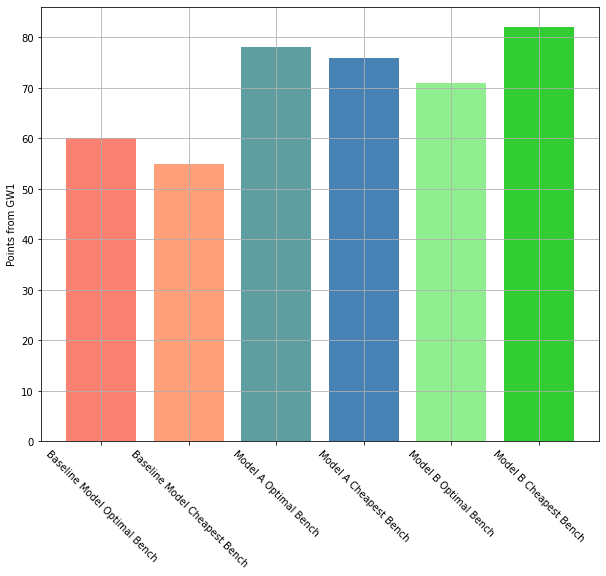

In [129]:
result = [60, 55, 78,76, 71 ,82]
label = ['Baseline Model Optimal Bench', 'Baseline Model Cheapest Bench', 'Model A Optimal Bench', 'Model A Cheapest Bench', 'Model B Optimal Bench', 'Model B Cheapest Bench']
plt.figure(figsize=(10, 8))
plt.grid()
plt.bar(label, result, color = ['salmon', 'lightsalmon','cadetblue','steelblue','lightgreen','limegreen'])
plt.xticks(rotation = -45);
plt.ylabel('Points from GW1')


Your ranking is:  1890038.6886949427
You are in the top:  21.000429874388253 %


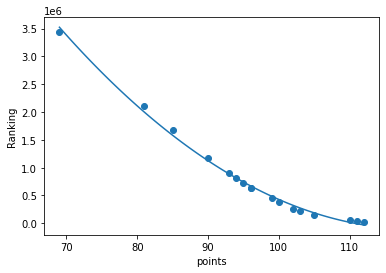

In [135]:
#I manually imported this data from fantasynutmeg.com: it has records of gw rankings from last year
#FPL deleted their records for last year unfortunately

gw1points = [81, 69, 96, 111, 95, 100, 112, 110, 93, 105, 94, 102,103,85, 96,90, 99]
ranking = [2114554, 3436438, 633476, 42237, 716748, 377647, 31939, 55419, 911355, 151567, 817703, 253013, 219935, 1676991, 633476, 1176051, 450455]

from sklearn.linear_model import LinearRegression
import numpy

mymodel = numpy.poly1d(numpy.polyfit(gw1points, ranking, 2)) #fit a polynomial
myline = numpy.linspace(69, 112, 100)

plt.scatter(gw1points, ranking)
plt.plot(myline, mymodel(myline))
plt.xlabel('points')
plt.ylabel('Ranking')
pred = mymodel(82)
print("Your ranking is: ", pred)
print("You are in the top: ", pred/9000000*100,"%") #there were over 9 million players in gw 1. 

In [ ]:
#baseline: 4940250, 54.9%
#model a opt: 2341216, 26.1%
#model a cheap: 2838353, 31.5%
#model b opt: 2461192, 27.3%
#model b cheap: 1890038, 21%